In [24]:
from graphviz import Digraph

In [25]:
from engine import Value

In [26]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

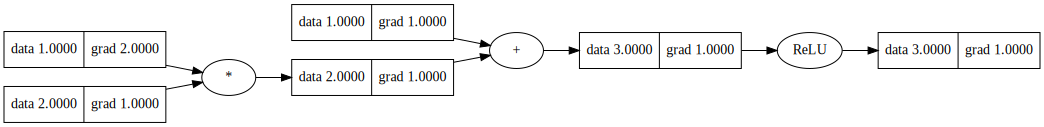

In [27]:
# a very simple example
x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

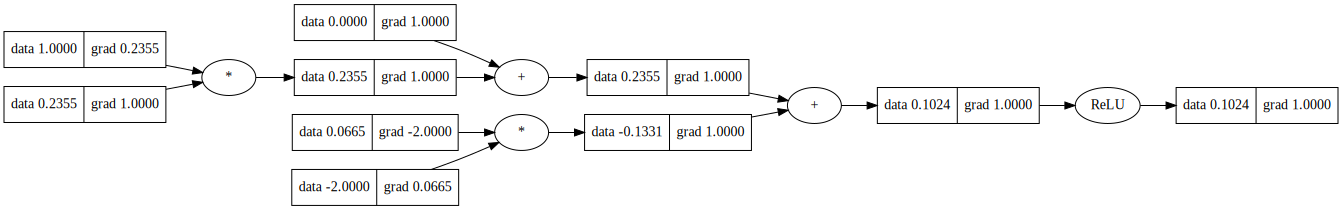

In [28]:
# a simple 2D neuron
import random
import nn

random.seed(1337)
n = nn.Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot

In [29]:
dot.render('gout')

'gout.svg'

# Traning on a dataset

In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
from engine import Value
from nn import Neuron, Layer, MLP

In [41]:
np.random.seed(1337)
random.seed(1337)

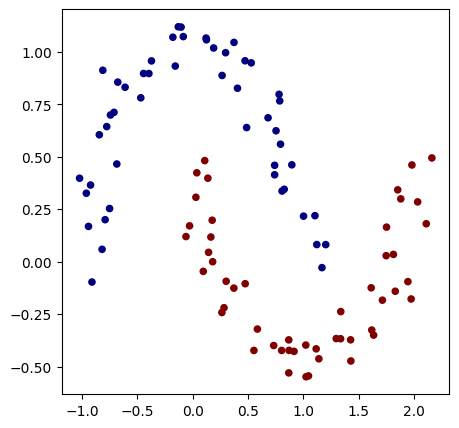

In [42]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [43]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [44]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [45]:
# pick one sample from the dataset
x_sample = list(map(Value, X[0]))

# forward pass through the model
y_pred = model(x_sample)

# backward pass to populate gradients
y_pred.backward()

# draw computation graph
dot = draw_dot(y_pred, format='svg', rankdir='LR')

dot.render('mlp_graph', view=True)

'mlp_graph.svg'

In [ ]:
dot

In [46]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.723590533697202, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584201, accuracy 82.0%
step 4 loss 0.3692793385976537, accuracy 84.0%
step 5 loss 0.313545481918522, accuracy 86.0%
step 6 loss 0.28142343497724337, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658036, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.21560951851922944, accuracy 91.0%
step 13 loss 0.23090378446402737, accuracy 93.0%
step 14 loss 0.20152151227899434, accuracy 92.0%
step 15 loss 0.22574506279282233, accuracy 93.0%
step 16 loss 0.19447987596204097, accuracy 92.0%
step 17 loss 0.21089496199246371, accuracy 93.0%
step 18 loss 0.159830773563036, accuracy 94.0%
step 19 loss 0.18453748746883933, accuracy 93.0%
step 20 loss 0.1897752285608763, accuracy

(-1.548639298268643, 1.951360701731357)

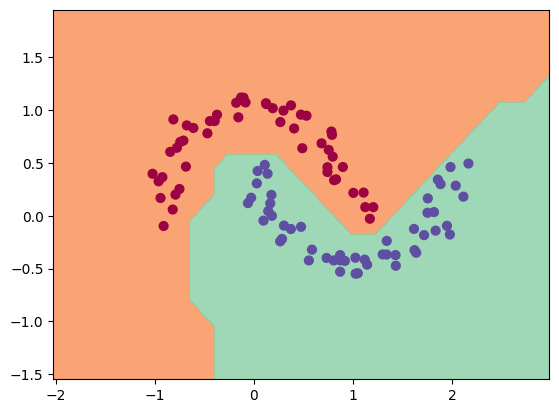

In [47]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Traning on other dataset

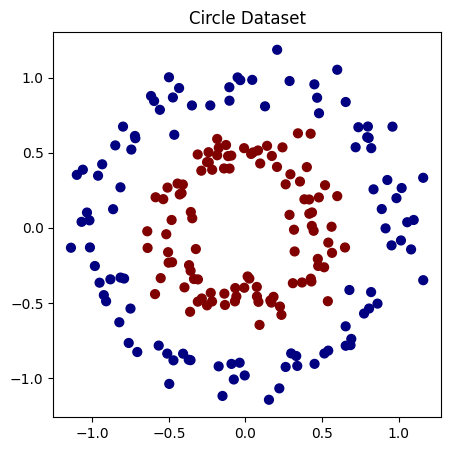

In [48]:
from sklearn.datasets import make_circles

# create concentric circles dataset
X, y = make_circles(n_samples=200, noise=0.1, factor=0.5)

y = y * 2 - 1   # convert labels from {0,1} to {-1,1}

# visualize dataset
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap='jet')
plt.title("Circle Dataset")
plt.show()

In [49]:
# reinitialize model for circles (important!)
model = MLP(2, [16, 16, 1])

for k in range(100):

    total_loss, acc = loss()

    model.zero_grad()
    total_loss.backward()

    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f"step {k} loss {total_loss.data:.4f}, accuracy {acc*100:.2f}%")

step 0 loss 1.0342, accuracy 49.00%
step 1 loss 1.2002, accuracy 50.00%
step 2 loss 1.5712, accuracy 50.00%
step 3 loss 0.8391, accuracy 50.00%
step 4 loss 0.7204, accuracy 73.00%
step 5 loss 0.6279, accuracy 80.00%
step 6 loss 0.5524, accuracy 84.00%
step 7 loss 0.4925, accuracy 96.00%
step 8 loss 0.5679, accuracy 76.00%
step 9 loss 0.7671, accuracy 57.50%
step 10 loss 0.4726, accuracy 83.00%
step 11 loss 0.5388, accuracy 71.50%
step 12 loss 0.6827, accuracy 65.50%
step 13 loss 0.6048, accuracy 66.00%
step 14 loss 0.4751, accuracy 82.00%
step 15 loss 0.4456, accuracy 77.50%
step 16 loss 0.5862, accuracy 72.50%
step 17 loss 0.5144, accuracy 74.00%
step 18 loss 0.3824, accuracy 86.00%
step 19 loss 0.3570, accuracy 86.00%
step 20 loss 0.5358, accuracy 75.00%
step 21 loss 0.4614, accuracy 76.00%
step 22 loss 0.3365, accuracy 87.00%
step 23 loss 0.3274, accuracy 87.00%
step 24 loss 0.3321, accuracy 87.00%
step 25 loss 0.2826, accuracy 89.50%
step 26 loss 0.2076, accuracy 92.50%
step 27 los

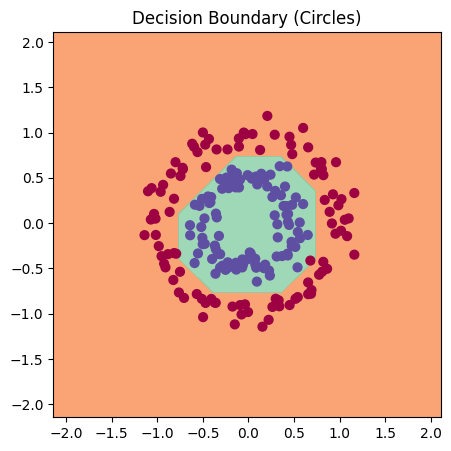

In [50]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title("Decision Boundary (Circles)")
plt.show()